In [1]:
import os
import numpy as np
import pandas as pd
import string
import re
from itertools import chain
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [2]:
import spacy
nlp = spacy.load('en_core_web_md')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

In [5]:
import time
from datetime import datetime
import string

In [6]:
import networkx as nx
import numpy as np
import torch
import torch.optim as optim

In [7]:
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Dataset
import torch_geometric.transforms as T
from torch_geometric import utils

In [8]:
import fasttext as ft

In [9]:
ft_model = ft.load_model('../models/fil9SkipGram.bin')

In [10]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stops = ENGLISH_STOP_WORDS
signs = string.punctuation + '“' + '’' + '”' + '*'
punct_translator = str.maketrans('', '', signs)

In [11]:
news = pd.read_json('../data/KEDatasets/KPTimes/KPTimes.train.jsonl', lines=True)

In [12]:
news.shape

(259923, 6)

In [13]:
news.loc[news['abstract'].str.len() <= 400].shape

(5299, 6)

In [14]:
news_short = news.loc[news['abstract'].str.len() <= 400].copy()

In [15]:
news.columns

Index(['id', 'categories', 'date', 'title', 'abstract', 'keyword'], dtype='object')

In [16]:
lines = []
with open('../data/LifehackerData/lifehacker-data.txt') as file:
    for line in file:
        fields = line.split('\t')
        lines.append(fields)

In [17]:
lh = pd.DataFrame(lines, columns=['abstract', 'keyword'])

In [18]:
lh['keyword'] = lh['keyword'].str.replace('\n', '')
lh['keyword'] = lh['keyword'].str.split()
lh = lh.explode('keyword')
lh['keyword'] = lh['keyword'].str.replace('_', ' ')

In [19]:
def check_in_text(row):
    return True if row[1].lower() in row[0].lower() else False

lh['inText'] = lh.apply(check_in_text, axis=1)

In [20]:
lh.loc[lh['inText']].shape, lh.shape

((3333, 3), (3333, 3))

#### Reading 500N-KPCrowd

In [21]:
%time
articles = '../data/500N-KPCrowd-v1.1/docsutf8/'
keys = '../data/500N-KPCrowd-v1.1/keys/'
txt_files = os.listdir(articles)
df_rows = []
for name in txt_files:
    if name[-4:] == '.txt':
        df_rows.append([])
        with open(articles+name) as file:
            print('Reading', name[:-4])
            lines = file.readlines()
            if len(lines) == 2:
                df_rows[-1].append(lines[1])
            elif len(lines) == 1:
                df_rows[-1].append(lines[0])
            else:
                print('Weird file format')
        main = name[:-4]
        with open(keys+main+'.key') as key:
            print('Reading keys for', name[:-4])
            kp = []
            for line in key:
                kp.append(line)
        df_rows[-1].append(kp)                

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs
Reading politics_us-20926420
Reading keys for politics_us-20926420
Reading business-20938151
Reading keys for business-20938151
Reading science-20927512
Reading keys for science-20927512
Reading politics_world-20779789
Reading keys for politics_world-20779789
Reading politics_world-20946632
Reading keys for politics_world-20946632
Reading business-20928735
Reading keys for business-20928735
Reading business-20928994
Reading keys for business-20928994
Reading science-20941050
Reading keys for science-20941050
Reading business-20956841
Reading keys for business-20956841
Reading crime-20938183
Reading keys for crime-20938183
Reading business-20935665
Reading keys for business-20935665
Reading politics_world-20920279
Reading keys for politics_world-20920279
Reading crime-20946675
Reading keys for crime-20946675
Reading business-20944935
Reading keys for business-20944935
Reading health-20941742
Reading keys for health-20941742

In [22]:
nkp = pd.DataFrame(df_rows, columns=['abstract', 'keyword'])
nkp.to_csv('../data/500N-KPCrowd.tsv', sep='\t')

In [23]:
nkp = nkp.explode('keyword')
nkp['keyword'] = nkp['keyword'].str.replace('\n', '')

In [24]:
nkp['keyword'] = nkp['keyword'].apply(lambda x: x.translate(punct_translator))
nkp['keyword'] = nkp['keyword'].str.lower()
nkp['abstract'] = nkp['abstract'].str.lower()
nkp['inText'] = nkp.apply(check_in_text, axis=1)

In [25]:
nkp['inText'].sum(), nkp.shape

(19955, (24615, 3))

In [26]:
nkp = nkp.loc[nkp['inText']].copy()

In [27]:
lh = lh.groupby('abstract').agg({'keyword': list}).reset_index()
nkp = nkp.groupby('abstract').agg({'keyword': list}).reset_index()

In [28]:
lh.shape, nkp.shape, news_short.shape

((1791, 2), (477, 2), (5299, 6))

#### Reading SemEval2017 paragraphs

In [29]:
%time
articles = '../data/SemEval2017/docsutf8/'
keys = '../data/SemEval2017/keys/'
txt_files = os.listdir(articles)
df_rows = []
for name in txt_files:
    if name[-4:] == '.txt':
        df_rows.append([])
        with open(articles+name) as file:
            print('Reading', name[:-4])
            lines = file.readlines()
            if len(lines) == 2:
                df_rows[-1].append(lines[1])
            elif len(lines) == 1:
                df_rows[-1].append(lines[0])
            else:
                print('Weird file format')
        main = name[:-4]
        with open(keys+main+'.key') as key:
            print('Reading keys for', name[:-4])
            kp = []
            for line in key:
                kp.append(line)
        df_rows[-1].append(kp)                

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs
Reading S0370269304006161
Reading keys for S0370269304006161
Reading S0032386114008428
Reading keys for S0032386114008428
Reading S0263822312000657
Reading keys for S0263822312000657
Reading S1359646214000165
Reading keys for S1359646214000165
Reading S000926141500651X
Reading keys for S000926141500651X
Reading S0378381215300297
Reading keys for S0378381215300297
Reading S107158191630074X
Reading keys for S107158191630074X
Reading S0370269304009232
Reading keys for S0370269304009232
Reading S0168365913002848
Reading keys for S0168365913002848
Reading S0301010415002189
Reading keys for S0301010415002189
Reading S0301679X14003272
Reading keys for S0301679X14003272
Reading S0370157312000105
Reading keys for S0370157312000105
Reading S0029549314002970
Reading keys for S0029549314002970
Reading S0022311515002391
Reading keys for S0022311515002391
Reading S0022311514008691
Reading keys for S0022311514008691
Reading S099775461200

In [30]:
len(df_rows), df_rows[0]

(493,
 ['Absorption events through the charged current reactions (2)νe+40Ar→e−+40K∗andν̄e+40Ar→e++40Cl∗. There is some uncertainty in predicting e−(e+) event rates for these processes which arise due to the nuclear model dependencies of the absorption cross section and the treatment of the Coulomb distortion of electron (positron) in the field of the residual nucleus. The nuclear absorption cross section for the charged current neutrino reactions in 40Ar relevant to supernova neutrino energies was first calculated by Raghavan\xa0[10] and Bahcall et al.\xa0[11] for Fermi transitions leading to isobaric analogue state (IAS) at 4.38\xa0MeV in 40K∗. Later Ormand et al.\xa0[12] used a shell model to calculate the Fermi and Gamow–Teller transitions. In these calculations Fermi function F(Z,Ee) was used to take into account the Coulomb effects. In a recent paper Bueno et al.\xa0[13] make use of a calculation by Martinez-Pinedo et al.\xa0[14] who use a shell model for Fermi and Gamow–Teller tr

In [31]:
sem = pd.DataFrame(df_rows, columns=['abstract', 'keyword'])
sem.to_csv('../data/SemEval2017.tsv', sep='\t')

In [32]:
sem = sem.explode('keyword')
sem['keyword'] = sem['keyword'].str.replace('\n', '')
sem['keyword'] = sem['keyword'].apply(lambda x: x.translate(punct_translator))
sem['keyword'] = sem['keyword'].str.lower()
sem['abstract'] = sem['abstract'].str.lower()
sem['inText'] = sem.apply(check_in_text, axis=1)

In [33]:
sem = sem.loc[sem['inText']].copy()
sem.shape

(7185, 3)

In [34]:
sem = sem.groupby('abstract').agg({'keyword': list}).reset_index()

In [35]:
sem.shape, lh.shape, nkp.shape, news_short.shape

((493, 2), (1791, 2), (477, 2), (5299, 6))

In [36]:
kp_df = pd.concat([sem, lh, nkp, news_short[['abstract', 'keyword']]])

In [37]:
#%store kp_df

In [38]:
kp_df = kp_df.reset_index(drop=True)

In [39]:
kp_df.index

RangeIndex(start=0, stop=8060, step=1)

In [40]:
kp_df['abstract'].duplicated().sum(), kp_df.shape

(6, (8060, 2))

In [41]:
kp_df = kp_df.drop_duplicates(subset='abstract')

In [42]:
kp_df['abstract'].duplicated().sum(), kp_df.shape

(0, (8054, 2))

In [43]:
kp_df.isnull().sum()

abstract    0
keyword     0
dtype: int64

In [44]:
kp_df = kp_df.explode('keyword')
kp_df['inText'] = kp_df.apply(check_in_text, axis=1)

In [45]:
kp_df.loc[kp_df['inText']].shape, kp_df.shape

((30473, 3), (35766, 3))

In [46]:
kp_df = kp_df.loc[kp_df['inText']].copy()
kp_df = kp_df.groupby('abstract').agg({'keyword': list}).reset_index()

In [47]:
kp_df.shape

(2761, 2)

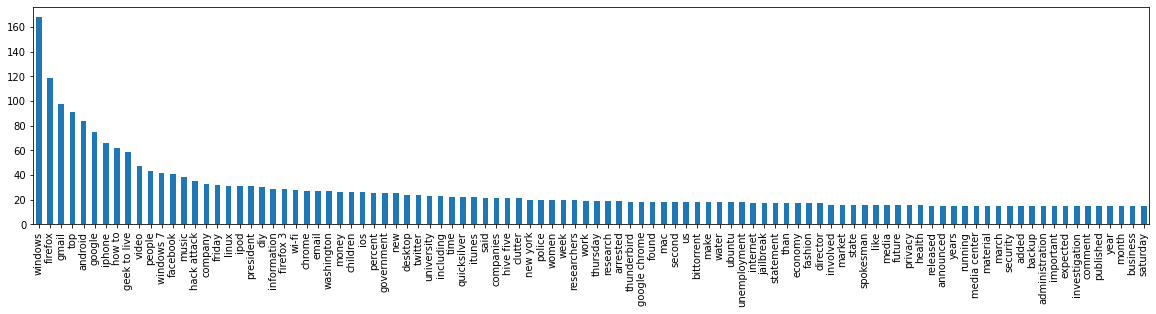

In [48]:
(kp_df.explode('keyword')['keyword'].value_counts()
 .nlargest(100).plot(kind='bar', figsize=(20, 4)));

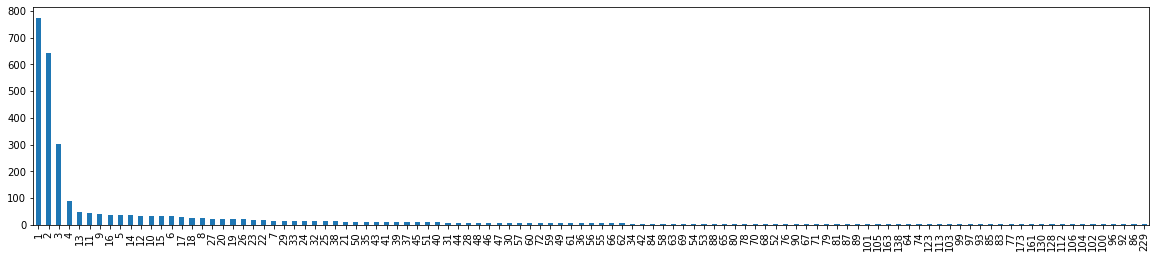

In [49]:
kp_df['keyword'].str.len().value_counts().plot(kind='bar', figsize=(20, 4));

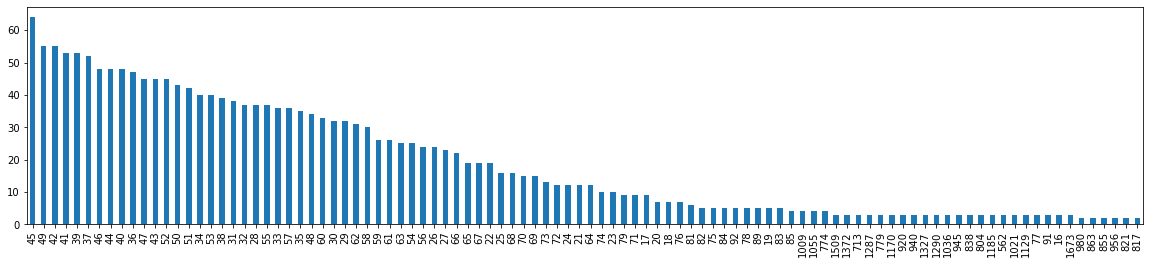

In [50]:
(kp_df['abstract'].str.len().value_counts()
 .nlargest(100).plot(kind='bar', figsize=(20, 4)));

In [51]:
kp_df.loc[kp_df['abstract'].str.len() >= 400].shape, kp_df.shape

((884, 2), (2761, 2))

In [52]:
kp_df = kp_df.loc[kp_df['abstract'].str.len() <= 400].copy()

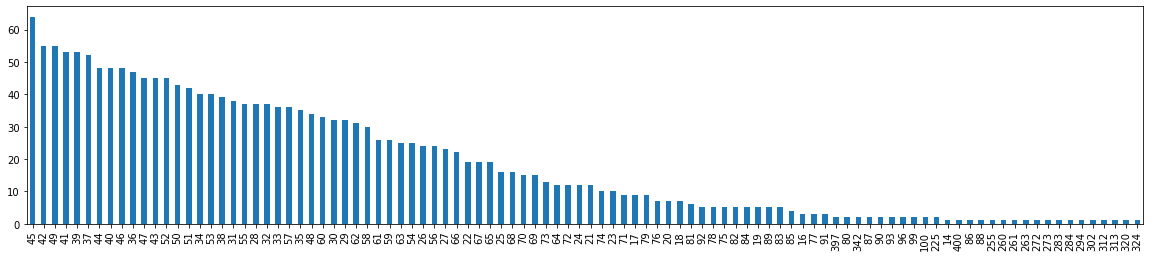

In [53]:
(kp_df['abstract'].str.len().value_counts()
 .nlargest(100).plot(kind='bar', figsize=(20, 4)));

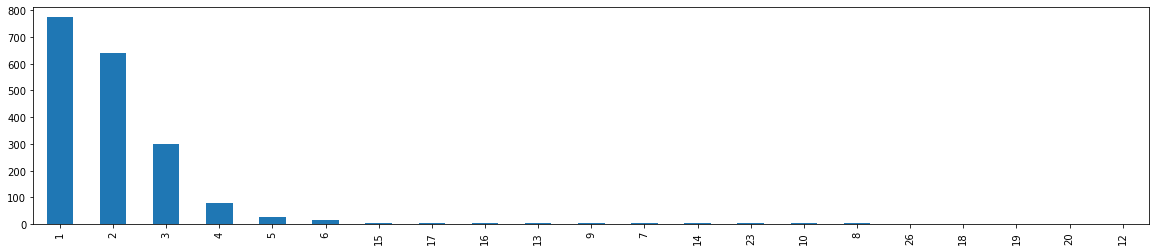

In [54]:
kp_df['keyword'].str.len().value_counts().plot(kind='bar', figsize=(20, 4));

In [55]:
kp_df.shape

(1878, 2)

In [56]:
kp_df = kp_df.reset_index(drop=True)

In [57]:
kp_df['clean'] = (kp_df['abstract']
                  .apply(lambda x: x.translate(punct_translator).lower()))

In [88]:
kp_df['keyword'] = (kp_df['keyword']
                    .apply(lambda x: [i.translate(punct_translator).lower() for i in x]))

In [89]:
kp_df['clean'].values

array(['crowdsourcing a better gmail presentation slides and notes',
       'windows cloud operating system release within a month',
       '5 ikea coat hanger offers solid cable management', ...,
       'youtube5 converts youtube videos to html5 for flash avoidance and cpu saving',
       'zoho writer online word processor',
       'new intro video with players working out ok ben goessling wrote from nats park on thursday finally a nationals television ad that doesnt suck nationals enquirer wrote when a version of this workout footage made it on television personally im all in favor of workout videos i just wish this one had matt stairs running stairs '],
      dtype=object)

#### Creating a Pytorch Geometric *Data* object for each article

In [90]:
def position_score(pos1, pos2):

    score = 0
    for i in pos1:
        for j in pos2:
            score += max(0, 1/(i-j))
    return score

def position_dict(ordered_vocab):
    
    position_dict = OrderedDict()
    for word in ordered_vocab:
        if word not in position_dict.keys():
            position_dict[word] = [i for i, w in enumerate(ordered_vocab) if w == word]
    return position_dict

def score_matrix(ordered_vocab):
    
    pos = position_dict(ordered_vocab)
    A_left = []
    A_right = []
    for word in pos.keys():
        left = []
        right = []
        for word2 in pos.keys():
            if word == word2:
                left.append(0)
                right.append(0)
            else:
                left_score = position_score(pos[word], pos[word2])
                left.append(left_score)
                right_score = position_score(pos[word2], pos[word])
                right.append(right_score)
        A_left.append(left)
        A_right.append(right)
    return np.array(A_left), np.array(A_right), pos.keys()


def make_matrices(vocab):
    Aleft, Aright, columns = score_matrix(vocab)
    Aleft_tilda = torch.from_numpy(Aleft + np.identity(Aleft.shape[0]))
    Aright_tilda = torch.from_numpy(Aright + np.identity(Aright.shape[0]))
    return Aleft_tilda, Aright_tilda, list(columns)

def get_kw_index(vocab, word):
    #import pdb;pdb.set_trace()
    try:
        return vocab.index(word)
    except ValueError:
        for i, v in enumerate(vocab):
            if word in v:
                return i
        return False
        
        

def make_kw_labels(keywords, vocab):
    labels = []
    found = []
    for key in keywords:
        kw_labels = []
        kw = key.split()
        for word in kw:
            ix = get_kw_index(vocab, word)
            assert ix in range(len(vocab))
            kw_labels.append([ix])
        kw_labels.append([len(vocab)-1])
        if kw_labels not in labels:
            labels.append(kw_labels)
        else:
            keywords.remove(key)
        
    return labels

def index_kp(keywords, vocab):
    kp = []
    for key in keywords:
        kw = key.split()
        ids = []
        for word in kw:
            ix = get_kw_index(vocab, word)
            assert ix in range(len(vocab))
            ids.append(ix)
        kp.append(ids)
    return kp
            

def make_DataObject(row):

    vocab, keywords = row['clean'], row['keyword']
    # adding EndOfString token to the vocabulary
    vocab = vocab.split()
    vocab.append('<EOS>')
    Aleft_tilda, Aright_tilda, columns = make_matrices(vocab)
    X = torch.tensor([ft_model.get_sentence_vector(w).tolist() for w in columns])
    #print(columns)
    data = Data(x=X)
    data.a_left = Aleft_tilda
    data.a_right = Aright_tilda
    data.words = columns
    labels = make_kw_labels(keywords, vocab)
    data.labels = labels
    data.kp = index_kp(keywords, vocab)
    return data

In [91]:
#kp_df['keyword'] = kp_df['keyword'].apply(lambda x: list(set(x)))

In [92]:
%pdb off

Automatic pdb calling has been turned OFF


In [93]:
#kp_df = kp_df.drop(3, axis=0)
kp_df.iloc[[37, 38, 39]]

,abstract,keyword,clean
38,add to-do lists to google calendar,[google calendar],add todo lists to google calendar
39,add-on compatibility reporter enables incompat...,"[firefox extensions, firefox, extension, compa...",addon compatibility reporter enables incompati...
40,aero shake clears your pre-windows 7 desktop,"[windows, windows 7]",aero shake clears your prewindows 7 desktop


In [94]:
%time a, b, c = kp_df.iloc[[37, 38, 39]].apply(make_DataObject, axis=1)

CPU times: user 13.7 ms, sys: 338 µs, total: 14 ms
Wall time: 11.1 ms


In [96]:
f = c
f.x.shape, f.words, f.labels, f.kp

(torch.Size([8, 100]),
 ['aero', 'shake', 'clears', 'your', 'prewindows', '7', 'desktop', '<EOS>'],
 [[[4], [7]], [[4], [5], [7]]],
 [[4], [4, 5]])

Labeling keywords are not diverse themselves sometimes. Modifying related to *make_DataObject* functions to fix that.

Testing on keywords again, after the modifications.

In [97]:
kp_df.iloc[[37, 38, 39]].loc[39]['keyword']

['firefox extensions', 'firefox', 'extension', 'compatibility']

In [98]:
%time a, b, c = kp_df.iloc[[37, 38, 39]].apply(make_DataObject, axis=1)

CPU times: user 11.2 ms, sys: 670 µs, total: 11.9 ms
Wall time: 9.58 ms


In [99]:
f = b
f.x.shape, f.words, f.labels, f.kp

(torch.Size([13, 100]),
 ['addon',
  'compatibility',
  'reporter',
  'enables',
  'incompatible',
  'firefox',
  'extensions',
  'reports',
  'if',
  'still',
  'not',
  'working',
  '<EOS>'],
 [[[5], [6], [12]], [[5], [12]], [[6], [12]], [[1], [12]]],
 [[5, 6], [5], [6], [1]])

In [101]:
%time kp_df['ptgeo_DataObj'] = kp_df.apply(make_DataObject, axis=1)

CPU times: user 683 ms, sys: 0 ns, total: 683 ms
Wall time: 680 ms


In [104]:
small_kpdf = kp_df.copy()

In [105]:
%store small_kpdf

Stored 'small_kpdf' (DataFrame)


In [106]:
!pwd

/home/masha/Desktop/DataScience/GNN/Project/GNN-NLP/notebooks


In [107]:
small_kpdf.to_csv('../data/small_kpdf27-01-21.tsv', sep='\t')